# Measuring distances between objects
This notebook demonstrates how to measure distance of objects in one image to the closest object in another image. A use-case for this is measuring the distance of objects such as cells to a vessel. The following procedure is demonstrated in 2D and should work analogously in 3D.

In [1]:
import numpy as np
import pyclesperanto_prototype as cle
import napari_simpleitk_image_processing as nsitk
import pandas as pd

As example data, we use two synthetic images: a binary image showing where a vessel is as stripe, and a label image showing where cells / objects are.

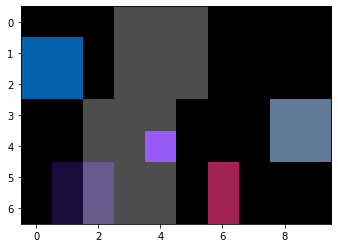

In [2]:
vessel = np.asarray([
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
])

objects = np.asarray([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 5, 5],
    [0, 0, 0, 0, 2, 0, 0, 0, 5, 5],
    [0, 4, 4, 0, 0, 0, 3, 0, 0, 0],
    [0, 4, 4, 0, 0, 0, 3, 0, 0, 0],
])

cle.imshow(vessel, continue_drawing=True)
cle.imshow(objects, labels=True, alpha=0.7)

## Distance maps
For measuring the average distance of labeled pixels to some other object, one strategy involes [distance maps](https://en.wikipedia.org/wiki/Distance_transform). Here we use the [signed Maurer distance map](https://itk.org/ITKExamples/src/Filtering/DistanceMap/MaurerDistanceMapOfBinary/Documentation.html) implemented in [SimpleITK](https://simpleitk.readthedocs.io/). More precisely, we use the scriptable napari-plugin [napari-simpleitk-image-processing](https://www.napari-hub.org/plugins/napari-simpleitk-image-processing) to access that map. If the values are positive, we are outside the vessel. Negative values suggest we are inside.

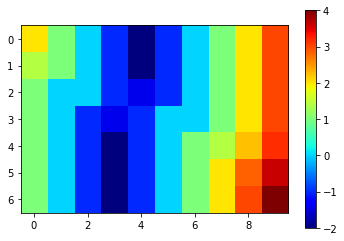

In [3]:
not_vessel = cle.binary_not(vessel)

distance_from_vessel = nsitk.signed_maurer_distance_map(not_vessel)

cle.imshow(distance_from_vessel, colorbar=True, colormap="jet")

## Object distance map
Next, we measure the average intensity in the distance map where the objects are. These intensities represent the average distance of these objects to the vessel. Background intensity in these maps (distance in our case) is 0, per definition.

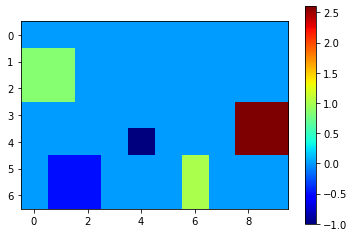

In [4]:
mean_distance_map = cle.mean_intensity_map(distance_from_vessel, objects)

cle.imshow(mean_distance_map, colorbar=True, colormap="jet")

Alternatively, to this visualization, we can also read out the average distance using pixel statistics and print them out using a [pandas Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [5]:
statistics = cle.statistics_of_labelled_pixels(distance_from_vessel, objects)

table = pd.DataFrame(statistics)
table = table[['label', 'mean_intensity']]
table = table.rename(columns={'mean_intensity':'mean_distance'})

table

,label,mean_distance
0,1,0.853553
1,2,-1.000000
2,3,1.000000
3,4,-0.500000
4,5,2.599586


## Filtering objects
You can also filter out object according to their distance to the vessel.

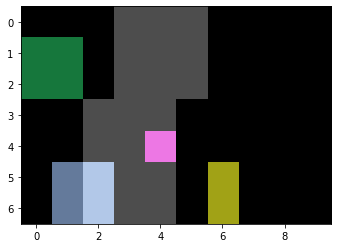

In [6]:
min_distance = -4
max_distance = 2
objects_close_by_vessel = cle.exclude_labels_with_map_values_out_of_range(
    mean_distance_map,
    objects,
    minimum_value_range=min_distance,
    maximum_value_range=max_distance
)

cle.imshow(vessel, continue_drawing=True)
cle.imshow(objects_close_by_vessel, labels=True, alpha=0.7)